In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

Train size: 1875
Test size: 209


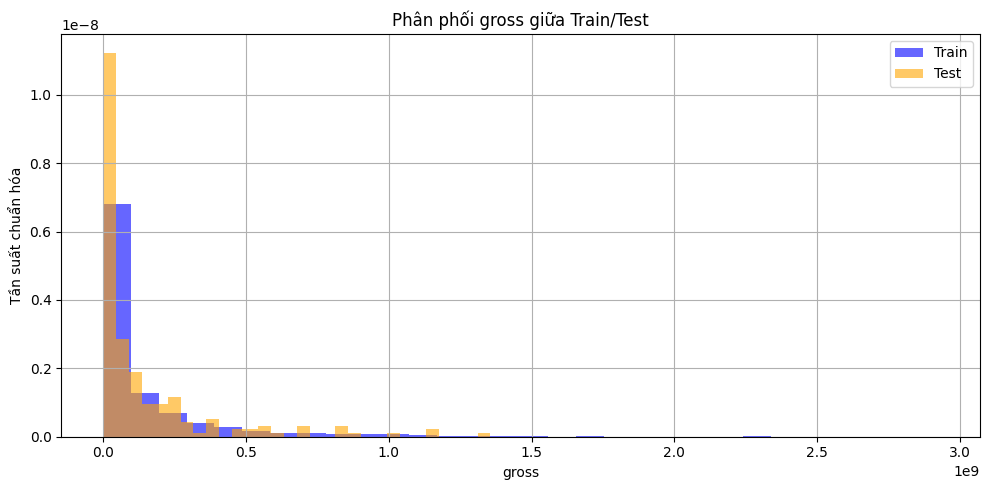

In [4]:
# Đọc dữ liệu
df = pd.read_csv("dataset/movies_data_processed_v3.csv")

# Rời rạc hóa target thành 10 nhóm (dùng gross_log hoặc cột bạn muốn chia theo)
y_binned = pd.qcut(df['gross'], q=10, labels=False, duplicates='drop')

# Chia train/test theo tỷ lệ 90/10
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, test_idx in splitter.split(df, y_binned):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]

# Lưu ra file CSV
df_train.to_csv("dataset/train.csv", index=False)
df_test.to_csv("dataset/test.csv", index=False)

# Thống kê
print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")


# Vẽ phân phối gross_log giữa Train và Test
plt.figure(figsize=(10, 5))
plt.hist(df_train['gross'], bins=30, alpha=0.6, label='Train', color='blue', density=True)
plt.hist(df_test['gross'], bins=30, alpha=0.6, label='Test', color='orange', density=True)
plt.title("Phân phối gross giữa Train/Test")
plt.xlabel("gross")
plt.ylabel("Tần suất chuẩn hóa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()